<a href="https://colab.research.google.com/github/YSW2/CV-KnowledgeDistillation/blob/master/%5BCV%5DKnowledge_Distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/CV/Knowledge distillation

/content/drive/MyDrive/CV/Knowledge distillation


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import time

# Check if GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Below we are preprocessing data for CIFAR-10. We use an arbitrary batch size of 128.
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading the CIFAR-10 dataset:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
#Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [7]:
# Deeper neural network class to be used as teacher:
class DeepNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Lightweight neural network class to be used as student:
class LightNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

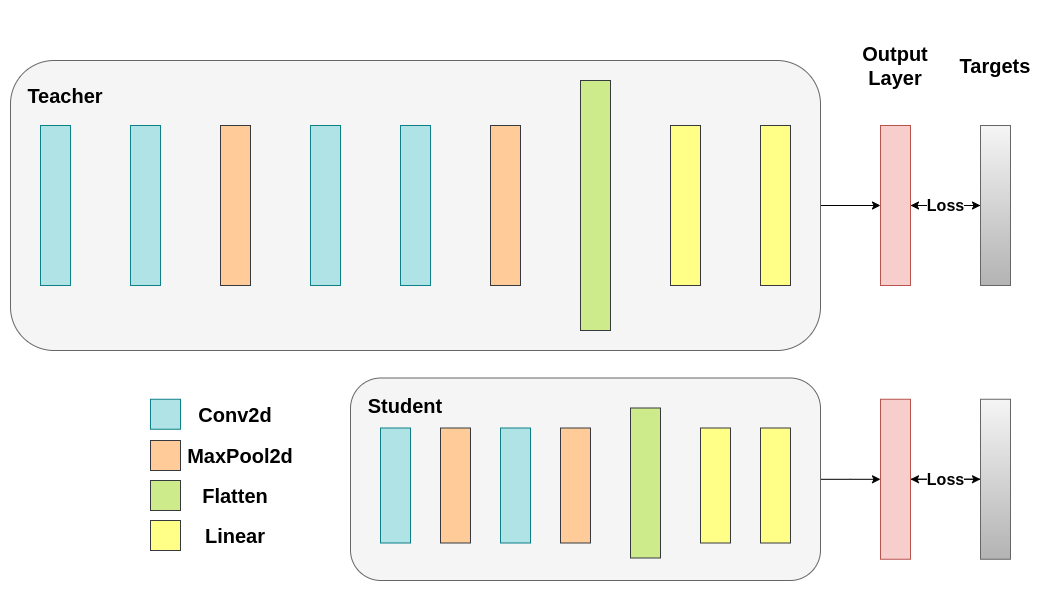

In [8]:
def train(model, train_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [9]:
torch.manual_seed(42)
nn_deep = DeepNN(num_classes=10).to(device)

In [10]:
# 훈련 시작 시간 기록
start_time = time.time()
train(nn_deep, train_loader, epochs=10, learning_rate=0.001, device=device)

# 훈련 종료 시간 기록 및 소요 시간 계산
end_time = time.time()
training_time_deep = end_time - start_time
print(f"DeepNN Training Time: {training_time_deep} seconds")


test_accuracy_deep = test(nn_deep, test_loader, device)


Epoch 1/10, Loss: 1.3607456145993888
Epoch 2/10, Loss: 0.8989276154266904
Epoch 3/10, Loss: 0.6979299292082677
Epoch 4/10, Loss: 0.5582170176231648
Epoch 5/10, Loss: 0.4280968378953007
Epoch 6/10, Loss: 0.32389923831081147
Epoch 7/10, Loss: 0.2344950716132703
Epoch 8/10, Loss: 0.18016362697114724
Epoch 9/10, Loss: 0.14252392876216824
Epoch 10/10, Loss: 0.13328442704456542
DeepNN Training Time: 8247.71537899971 seconds
Test Accuracy: 74.69%


In [11]:
# Instantiate the lightweight network:
torch.manual_seed(42)
nn_light = LightNN(num_classes=10).to(device)

In [12]:
torch.manual_seed(42)
new_nn_light = LightNN(num_classes=10).to(device)

# Print the norm of the first layer of the initial lightweight model
print("Norm of 1st layer of nn_light:", torch.norm(nn_light.features[0].weight).item())
# Print the norm of the first layer of the new lightweight model
print("Norm of 1st layer of new_nn_light:", torch.norm(new_nn_light.features[0].weight).item())

Norm of 1st layer of nn_light: 2.327361822128296
Norm of 1st layer of new_nn_light: 2.327361822128296


In [13]:
total_params_deep = "{:,}".format(sum(p.numel() for p in nn_deep.parameters()))
print(f"DeepNN parameters: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in nn_light.parameters()))
print(f"LightNN parameters: {total_params_light}")

DeepNN parameters: 1,186,986
LightNN parameters: 267,738


In [14]:
# 경량모델 훈련시간 측정
start_time = time.time()
train(nn_light, train_loader, epochs=10, learning_rate=0.001, device=device)

end_time = time.time()
training_time_light = end_time - start_time
print(f"LightNN Training Time: {training_time_light} seconds")

test_accuracy_light_ce = test(nn_light, test_loader, device)

Epoch 1/10, Loss: 1.4591180250772735
Epoch 2/10, Loss: 1.1508304775523408
Epoch 3/10, Loss: 1.0211140293904277
Epoch 4/10, Loss: 0.9257420406622046
Epoch 5/10, Loss: 0.8497451241973721
Epoch 6/10, Loss: 0.7829224599901673
Epoch 7/10, Loss: 0.7149976584917445
Epoch 8/10, Loss: 0.658251344547857
Epoch 9/10, Loss: 0.6082006259190152
Epoch 10/10, Loss: 0.5529454486906681
LightNN Training Time: 381.54357266426086 seconds
Test Accuracy: 69.62%


In [15]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy: {test_accuracy_light_ce:.2f}%")

Teacher accuracy: 74.69%
Student accuracy: 69.62%


In [ ]:
def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = -torch.sum(soft_targets * soft_prob) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
train_knowledge_distillation(teacher=nn_deep, student=new_nn_light, train_loader=train_loader, epochs=10, learning_rate=0.001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)
test_accuracy_light_ce_and_kd = test(new_nn_light, test_loader, device)

# Compare the student test accuracy with and without the teacher, after distillation
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")

Epoch 1/10, Loss: 1.106545554097656
Epoch 2/10, Loss: 1.0297689675675024
Epoch 3/10, Loss: 0.9778938589193632


In [ ]:
class ModifiedDeepNNCosine(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedDeepNNCosine, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        flattened_conv_output = torch.flatten(x, 1)
        x = self.classifier(flattened_conv_output)
        flattened_conv_output_after_pooling = torch.nn.functional.avg_pool1d(flattened_conv_output, 2)
        return x, flattened_conv_output_after_pooling

# Create a similar student class where we return a tuple. We do not apply pooling after flattening.
class ModifiedLightNNCosine(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedLightNNCosine, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        flattened_conv_output = torch.flatten(x, 1)
        x = self.classifier(flattened_conv_output)
        return x, flattened_conv_output

# We do not have to train the modified deep network from scratch of course, we just load its weights from the trained instance
modified_nn_deep = ModifiedDeepNNCosine(num_classes=10).to(device)
modified_nn_deep.load_state_dict(nn_deep.state_dict())

# Once again ensure the norm of the first layer is the same for both networks
print("Norm of 1st layer for deep_nn:", torch.norm(nn_deep.features[0].weight).item())
print("Norm of 1st layer for modified_deep_nn:", torch.norm(modified_nn_deep.features[0].weight).item())

# Initialize a modified lightweight network with the same seed as our other lightweight instances. This will be trained from scratch to examine the effectiveness of cosine loss minimization.
torch.manual_seed(42)
modified_nn_light = ModifiedLightNNCosine(num_classes=10).to(device)
print("Norm of 1st layer:", torch.norm(modified_nn_light.features[0].weight).item())

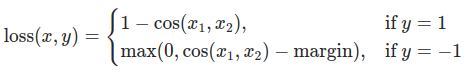

In [18]:
# Create a sample input tensor
sample_input = torch.randn(128, 3, 32, 32).to(device) # Batch size: 128, Filters: 3, Image size: 32x32

# Pass the input through the student
logits, hidden_representation = modified_nn_light(sample_input)

# Print the shapes of the tensors
print("Student logits shape:", logits.shape) # batch_size x total_classes
print("Student hidden representation shape:", hidden_representation.shape) # batch_size x hidden_representation_size

# Pass the input through the teacher
logits, hidden_representation = modified_nn_deep(sample_input)

# Print the shapes of the tensors
print("Teacher logits shape:", logits.shape) # batch_size x total_classes
print("Teacher hidden representation shape:", hidden_representation.shape) # batch_size x hidden_representation_size

Student logits shape: torch.Size([128, 10])
Student hidden representation shape: torch.Size([128, 1024])
Teacher logits shape: torch.Size([128, 10])
Teacher hidden representation shape: torch.Size([128, 1024])


In [19]:
def train_cosine_loss(teacher, student, train_loader, epochs, learning_rate, hidden_rep_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    cosine_loss = nn.CosineEmbeddingLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model and keep only the hidden representation
            with torch.no_grad():
                _, teacher_hidden_representation = teacher(inputs)

            # Forward pass with the student model
            student_logits, student_hidden_representation = student(inputs)

            # Calculate the cosine loss. Target is a vector of ones. From the loss formula above we can see that is the case where loss minimization leads to cosine similarity increase.
            hidden_rep_loss = cosine_loss(student_hidden_representation, teacher_hidden_representation, target=torch.ones(inputs.size(0)).to(device))

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = hidden_rep_loss_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

In [20]:
def test_multiple_outputs(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, _ = model(inputs) # Disregard the second tensor of the tuple
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [21]:
# 훈련 시작 시간 기록
cos_start_time = time.time()
train_cosine_loss(teacher=modified_nn_deep, student=modified_nn_light, train_loader=train_loader, epochs=10, learning_rate=0.001, hidden_rep_loss_weight=0.25, ce_loss_weight=0.75, device=device)
test_accuracy_light_ce_and_cosine_loss = test_multiple_outputs(modified_nn_light, test_loader, device)

# 훈련 종료 시간 기록 및 소요 시간 계산
cos_end_time = time.time()
cos_training_time_deep = cos_end_time - cos_start_time
print(f"cos_DeepNN Training Time: {cos_training_time_deep} seconds")

# Train and test the lightweight network with cross entropy loss


Epoch 1/10, Loss: 1.291271405451743
Epoch 2/10, Loss: 1.067605065262836
Epoch 3/10, Loss: 0.970535113683442
Epoch 4/10, Loss: 0.9007759019541923
Epoch 5/10, Loss: 0.8419071759104424
Epoch 6/10, Loss: 0.7945814596112731
Epoch 7/10, Loss: 0.7544531027984132
Epoch 8/10, Loss: 0.7184599862074303
Epoch 9/10, Loss: 0.6811274387647429
Epoch 10/10, Loss: 0.6497856105684929
Test Accuracy: 71.17%
cos_DeepNN Training Time: 3377.172976255417 seconds


In [ ]:
# Pass the sample input only from the convolutional feature extractor
convolutional_fe_output_student = nn_light.features(sample_input)
convolutional_fe_output_teacher = nn_deep.features(sample_input)

# Print their shapes
print("Student's feature extractor output shape: ", convolutional_fe_output_student.shape)
print("Teacher's feature extractor output shape: ", convolutional_fe_output_teacher.shape)

In [ ]:
class ModifiedDeepNNRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedDeepNNRegressor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        conv_feature_map = x
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, conv_feature_map

class ModifiedLightNNRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedLightNNRegressor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Include an extra regressor (in our case linear)
        self.regressor = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        regressor_output = self.regressor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, regressor_output

In [ ]:
def train_mse_loss(teacher, student, train_loader, epochs, learning_rate, feature_map_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Again ignore teacher logits
            with torch.no_grad():
                _, teacher_feature_map = teacher(inputs)

            # Forward pass with the student model
            student_logits, regressor_feature_map = student(inputs)

            # Calculate the loss
            hidden_rep_loss = mse_loss(regressor_feature_map, teacher_feature_map)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = feature_map_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# Notice how our test function remains the same here with the one we used in our previous case. We only care about the actual outputs because we measure accuracy.

# Initialize a ModifiedLightNNRegressor
torch.manual_seed(42)
modified_nn_light_reg = ModifiedLightNNRegressor(num_classes=10).to(device)

# We do not have to train the modified deep network from scratch of course, we just load its weights from the trained instance
modified_nn_deep_reg = ModifiedDeepNNRegressor(num_classes=10).to(device)
modified_nn_deep_reg.load_state_dict(nn_deep.state_dict())

# Train and test once again
train_mse_loss(teacher=modified_nn_deep_reg, student=modified_nn_light_reg, train_loader=train_loader, epochs=10, learning_rate=0.001, feature_map_weight=0.25, ce_loss_weight=0.75, device=device)
test_accuracy_light_ce_and_mse_loss = test_multiple_outputs(modified_nn_light_reg, test_loader, device)

In [25]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")
print(f"Student accuracy with CE + CosineLoss: {test_accuracy_light_ce_and_cosine_loss:.2f}%")
print(f"Student accuracy with CE + RegressorMSE: {test_accuracy_light_ce_and_mse_loss:.2f}%")

Teacher accuracy: 74.69%
Student accuracy without teacher: 69.62%
Student accuracy with CE + KD: 71.04%
Student accuracy with CE + CosineLoss: 71.17%
Student accuracy with CE + RegressorMSE: 70.83%
Teacher accuracy: 74.69%
Student accuracy without teacher: 69.62%
Student accuracy with CE + KD: 71.04%
Student accuracy with CE + CosineLoss: 71.17%
Student accuracy with CE + RegressorMSE: 70.83%
